# BPJS Hackathon 2021

## Import Packages & Data

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, recall_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fraud_detection_train.csv')
df.head()

,visit_id,kdkc,dati2,typeppk,jkpst,umur,jnspelsep,los,cmg,severitylevel,...,proc63_67,proc68_70,proc71_73,proc74_75,proc76_77,proc78_79,proc80_99,proce00_e99,procv00_v89,label
0,1,1107,150,SB,P,64,2,0,F,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1303,200,C,L,45,1,9,E,3,...,0,0,0,0,0,0,4,0,0,1
2,3,1114,172,B,P,34,2,0,Q,0,...,0,0,0,0,0,0,0,0,0,1
3,4,601,90,SC,L,34,2,0,Q,0,...,0,0,0,0,0,0,0,0,0,1
4,5,1006,130,B,L,27,2,0,F,0,...,0,0,0,0,0,0,0,0,0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200217 entries, 0 to 200216
Data columns (total 53 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   visit_id       200217 non-null  int64 
 1   kdkc           200217 non-null  int64 
 2   dati2          200217 non-null  int64 
 3   typeppk        200217 non-null  object
 4   jkpst          200217 non-null  object
 5   umur           200217 non-null  int64 
 6   jnspelsep      200217 non-null  int64 
 7   los            200217 non-null  int64 
 8   cmg            200217 non-null  object
 9   severitylevel  200217 non-null  int64 
 10  diagprimer     200217 non-null  object
 11  dx2_a00_b99    200217 non-null  int64 
 12  dx2_c00_d48    200217 non-null  int64 
 13  dx2_d50_d89    200217 non-null  int64 
 14  dx2_e00_e90    200217 non-null  int64 
 15  dx2_f00_f99    200217 non-null  int64 
 16  dx2_g00_g99    200217 non-null  int64 
 17  dx2_h00_h59    200217 non-null  int64 
 18  dx2_

In [4]:
# Check data duplicates
df.duplicated().sum().any()

False

## Exploratory Data Analysis

In [5]:
# Check missing values
df.isna().sum().any()

False

In [6]:
# Encode object data
label = LabelEncoder()

object_col = df.select_dtypes('object').columns
df[object_col] = df[object_col].apply(lambda x: label.fit_transform(x.str.strip()))

In [7]:
# Data correlation
correlation = np.abs(df.corr()['label']).\
    sort_values(ascending = False).reset_index().\
    rename(columns = {'index': 'Column', 'label': 'Correlation'})
correlation

,Column,Correlation
0,label,1.000000
1,visit_id,0.866024
2,typeppk,0.057364
3,jnspelsep,0.053215
4,proc39_45,0.043502
5,los,0.040318
6,proc74_75,0.038108
7,proc80_99,0.037421
8,dati2,0.026380
9,proc46_51,0.026325


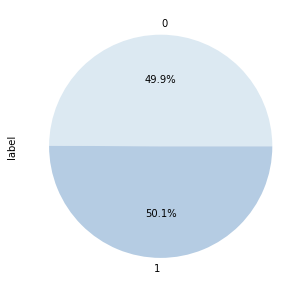

In [8]:
# Plot label count comparison
plt.figure(figsize=(5,10))
color = sns.color_palette('BuPu')
df['label'].value_counts().sort_values().plot(kind='pie', colors=color, autopct = '%1.1f%%')
plt.show();

## Train Test Split

In [9]:
X = df.drop(['label', 'visit_id'], axis=1)
y = df.label

In [10]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=200)

In [11]:
# Scaling data 0 to 1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Machine Learning Model

In [12]:
model = RandomForestClassifier()

In [13]:
model.fit(X_train, y_train)

RandomForestClassifier()

In [14]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.72      0.72     19993
           1       0.72      0.71      0.71     20051

    accuracy                           0.71     40044
   macro avg       0.71      0.71      0.71     40044
weighted avg       0.71      0.71      0.71     40044



In [15]:
recall=[]
recall.append(round(recall_score(y_test, y_pred)*100,2))

## Tuning RandomForest Hyperparameter

In [16]:
grid_params = {
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [50, 100]
}

In [17]:
# Data sampling to find

df_sample = df.drop(['visit_id'], axis=1)

df_sample_0 = df[df['label'] == 0].sample(10000, random_state=200)
df_sample_1 = df[df['label'] == 1].sample(10000, random_state=200)

df_sample_concat = pd.concat([df_sample_0, df_sample_1])

sample_train_X = df_sample_concat.drop('label', axis=1) 
sample_train_y = df_sample_concat.label

In [18]:
randomizedCV = RandomizedSearchCV(model, grid_params, n_iter=100, cv=5, random_state=200)

In [19]:
start = time.time()
tuned_model = randomizedCV.fit(sample_train_X, sample_train_y)
end = time.time()

print(f'Time spent: {(end-start)/60} minutes')

Time spent: 5.665349590778351 minutes


In [20]:
print(tuned_model.best_params_)

{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}


In [23]:
tuned_model_ = RandomForestClassifier(n_estimators=100,
                                      min_samples_split=10, 
                                      min_samples_leaf=1, 
                                      max_features='auto', 
                                      max_depth=100, 
                                      bootstrap=True)

In [24]:
tuned_model_.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, min_samples_split=10)

In [25]:
y_pred_tuned = tuned_model_.predict(X_test)

print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72     19993
           1       0.72      0.72      0.72     20051

    accuracy                           0.72     40044
   macro avg       0.72      0.72      0.72     40044
weighted avg       0.72      0.72      0.72     40044



In [26]:
recall.append(round(recall_score(y_test, y_pred_tuned)*100,2))

In [27]:
recall = pd.DataFrame(recall, index =['Before tuned', 'After tuned'], columns =['Recall Score'])
recall

,Recall Score
Before tuned,70.68
After tuned,71.56
